#### Loading libraries

In [1]:
# Load tensorflow
import tensorflow as tf
# Below command is to avoid the known bug which prevents computation on some GPU devices
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
# Load preprocessing tools
from scipy.ndimage.filters import gaussian_filter
from tensorflow.keras.utils import to_categorical
from PIL import Image
# Load model building blocks
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
# Load pre-trained model library
from tensorflow.keras import applications
# Load miscelaneous libraries
import numpy as np
import os
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
import gc

#### Define paths

In [2]:
image_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'image_data', 'test')
labels_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'labels', 'test')
models_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'models')

#### Define image processor and data generator

In [3]:
%run '/home/renat_sergazinov/python-git-workspace/PhotoForceReconML/data_loader.py'

#### Load the data

In [4]:
#--- Load images ---#
# Extract individual image paths
img_paths = {}
for k in range(2, 7):
    path_prefix = os.path.join(image_path, str(k))
    img_paths[k] = [os.path.join(path_prefix, name) for name in sorted(os.listdir(path_prefix), key = sorter)]
# Create data generators
gaussblur = GaussBlur(1)
params = {'dim': (128, 128), 'n_channels': 3, 'rescale': 1 / 255, 
          'preprocessing_func': gaussblur.blur}
# Load images (for all number of forces) as matrix
X = dict()
for k in range(2, 7): 
    test_generator = DataGenerator(img_paths[k], **params)   
    X[k] = test_generator.generate()

In [5]:
#--- Load magnitude labels ---#
y_lm = dict()
for k in range(2, 7): y_lm[k] = np.load(os.path.join(labels_path, str(k), 'mags.npy'))

In [33]:
#--- Split magnitudes into bins ---#
bins = {}
bin_edges = np.linspace(0,1.5,30)
for k in range(2, 7): bins[k] = np.digitize(np.mean(y_lm[k], 1), bins = bin_edges)

#### Load and test models

In [7]:
#--- Load models ---#
models_m = dict()                         
for k in range(2, 7): 
    models_m[k] = load_model(os.path.join(models_path, 'vgg19_mags_'+str(k)+'.h5'))
    models_m[k].compile(metrics = ['mean_absolute_error', "mean_absolute_percentage_error"])

In [31]:
#--- Test models ---#
error_mae = np.empty([len(bin_edges) - 1, 5]) * np.nan 
error_mape = np.empty([len(bin_edges) - 1, 5]) * np.nan
for k in range(2, 7):
    print("Num forces: ", k)
    for i in range(1, len(bin_edges) - 1):
        if (sum(bins[k] == i) > 0):
            print("Bin: ", i)
            loss = models_m[k].evaluate(X[k][bins[k] == i, ], y_lm[k][bins[k] == i, ])
            error_mae[i - 1, k - 2] = loss[1]
            error_mape[i - 1, k - 2] = loss[2]

Num forces:  2
Bin:  1
14/14 [==============================] - 0s 32ms/step - loss: 0.0000e+00 - mean_absolute_error: 0.0429 - mean_absolute_percentage_error: 157.4326
Bin:  2
15/15 [==============================] - 0s 33ms/step - loss: 0.0000e+00 - mean_absolute_error: 0.0207 - mean_absolute_percentage_error: 31.7409
Bin:  3
10/10 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - mean_absolute_error: 0.0027 - mean_absolute_percentage_error: 2.0713
Bin:  4
9/9 [==============================] - 0s 30ms/step - loss: 0.0000e+00 - mean_absolute_error: 0.0053 - mean_absolute_percentage_error: 2.8711
Bin:  5
15/15 [==============================] - 0s 32ms/step - loss: 0.0000e+00 - mean_absolute_error: 0.0059 - mean_absolute_percentage_error: 2.4939
Bin:  6
9/9 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - mean_absolute_error: 0.0061 - mean_absolute_percentage_error: 2.1020
Bin:  7
14/14 [==============================] - 0s 31ms/step - loss: 0.00

In [53]:
df_error_mae = pd.DataFrame(error_mae, columns = [str(i) + " forces" for i in range(2, 7)])
df_error_mae["Mean bin magnitude"] = (bin_edges[1:] - bin_edges[:-1]) / 2 + bin_edges[:-1]
df_error_mae = pd.melt(df_error_mae, id_vars=["Mean bin magnitude"], value_name="Mean absolute error", var_name="Forces")

<AxesSubplot:xlabel='Mean bin magnitude', ylabel='Mean absolute error'>

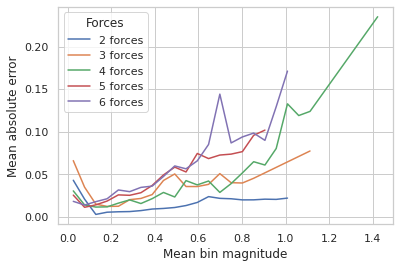

In [54]:
sns.set_theme(style="whitegrid")
sns.lineplot(data=df_error_mae, x="Mean bin magnitude", y="Mean absolute error", hue="Forces")

In [55]:
df_error_mape = pd.DataFrame(error_mape, columns = [str(i) + " forces" for i in range(2, 7)])
df_error_mape["Mean bin magnitude"] = (bin_edges[1:] - bin_edges[:-1]) / 2 + bin_edges[:-1]
df_error_mape = pd.melt(df_error_mape, id_vars=["Mean bin magnitude"], value_name="Mean absolute percent error", var_name="Forces")

<AxesSubplot:xlabel='Mean bin magnitude', ylabel='Mean absolute percent error'>

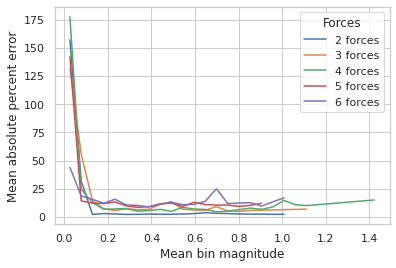

In [56]:
sns.lineplot(data=df_error_mape, x="Mean bin magnitude", y="Mean absolute percent error", hue="Forces")